In [75]:
import os
import pickle
import numpy as np
import pandas as pd
import config
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.special import expit, logit

try:
    import config
except ImportError:
    print("ERROR: config.py not found. Please ensure it's in the same directory.")
    # Create a dummy config for the script to run without error
    class DummyConfig:
        T_ANALYSIS_LENGTH = 200
        SCENARIOS = [{
            "id": 'S11', "cfr_type_code": 'C2', "num_interventions_K_true": 2,
            "cfr_params": {"cfr_start": 0.03, "cfr_end": 0.01},
            "true_beta_abs_0": np.array([1.0, 1.0]), "true_beta_signs_0": np.array([-1.0, 1.0]),
            "true_lambda_0": np.array([1.0, 1.0]), "true_intervention_times_0": np.array([200/3, 400/3])
        }]
    config = DummyConfig()

# --- Define Paths ---
BASE_OUTPUT_DIR = './simulation_outputs/'
POSTERIOR_SUMMARY_DIR = os.path.join(BASE_OUTPUT_DIR, 'posterior_summaries/')
BENCHMARK_RESULTS_DIR = os.path.join(BASE_OUTPUT_DIR, 'benchmarks_results/')
PLOT_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, 'plots/')
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

In [102]:
def generate_ground_truth(scenario_id):
    """
    Reconstructs the ground truth data for a given scenario using the central config file.
    """
    try:
        scenario_info = next(s for s in config.SCENARIOS if s['id'] == scenario_id)
    except StopIteration:
        raise ValueError(f"Scenario '{scenario_id}' not found in config.py")
        
    T = config.T_ANALYSIS_LENGTH
    time_pts = np.arange(T)
    
    # 1. Generate the baseline (counterfactual) CFR: zeta_t_true
    cfr_type = scenario_info['cfr_type_code']
    params = scenario_info['cfr_params']
    
    if cfr_type == 'C1': # Constant
        zeta_t_true = np.full(T, params['cfr_const'])
    elif cfr_type == 'C2': # Linear
        zeta_t_true = np.linspace(params['cfr_start'], params['cfr_end'], T)
    elif cfr_type == 'C3': # Sine wave
        zeta_t_true = params['cfr_mean'] + params['amp'] * np.sin(2 * np.pi * params['freq'] * time_pts / T)
    elif cfr_type == 'C4': # Gaussian Kernel
        peak_t = params.get('peak_t', params['peak_t_factor'] * T)
        peak_w = params.get('peak_w', params['peak_w_factor'] * T)
        zeta_t_true = params['cfr_base'] + params['peak_h'] * np.exp(-((time_pts - peak_t)**2) / (2 * peak_w**2))
    else:
        raise ValueError(f"Unknown CFR type '{cfr_type}' in config.")

    # 2. Generate the intervention effect
    num_interventions = scenario_info['num_interventions_K_true']
    I_eff_true = np.zeros(T)
    if num_interventions > 0:
        true_betas = scenario_info['true_beta_abs_0'] * scenario_info['true_beta_signs_0']
        true_lambdas = scenario_info['true_lambda_0']
        true_times = scenario_info['true_intervention_times_0']
        
        for k in range(num_interventions):
            time_since_intervention = np.maximum(0, time_pts - true_times[k])
            Z_k = 1 - np.exp(-true_lambdas[k] * time_since_intervention)
            I_eff_true += Z_k * true_betas[k]
            
    # 3. Generate the factual CFR: r_t_true
    # CORRECTED LOGIC: Ensure addition happens on the logit scale before converting back
    logit_zeta = logit(np.clip(zeta_t_true, 1e-6, 1-1e-6))
    logit_factual = logit_zeta + I_eff_true
    r_t_true = expit(logit_factual)

    # 4. Return a dictionary mimicking the old truth object structure
    truth = {
        'r_t_true': r_t_true,
        'zeta_t_true': zeta_t_true,
        **scenario_info # Add all other info from the config dict
    }
    return truth


def load_data(scenario_id, mc_run_id):
    """Loads posterior summaries and benchmark results for a specific run."""
    run_number = mc_run_id + 1
    summary_filename = f"scen_{scenario_id}_run_{run_number}_posterior_summary.npz"
    benchmark_filename = f"scen_{scenario_id}_run_{run_number}_benchmark_results.npz"
    
    summary_path = os.path.join(POSTERIOR_SUMMARY_DIR, summary_filename)
    benchmark_path = os.path.join(BENCHMARK_RESULTS_DIR, benchmark_filename)

    if not all(os.path.exists(p) for p in [summary_path, benchmark_path]):
        raise FileNotFoundError(f"Data for {scenario_id}, run {run_number} not found.")

    posterior_summary = np.load(summary_path)
    benchmark_results = np.load(benchmark_path)
        
    return posterior_summary, benchmark_results

def format_param_text(summary, benchmark, truth):
    """Formats the parameter estimates from summary data for display on the plots."""
    text_lines = ["--- Proposed Model ---"]
    num_interventions = truth['num_interventions_K_true']
    
    if num_interventions == 0:
        return "No Interventions"

    # NOTE: According to user, 'beta_mean' is not in posterior_summary.npz
    # If it were, the code would be here.
    if 'beta_mean' in summary and len(summary['beta_mean']) == num_interventions:
        for i in range(num_interventions):
            mean_beta = summary['beta_mean'][i]
            ci_low = summary['beta_q025'][i]
            ci_high = summary['beta_q975'][i]
            true_beta = truth['true_beta_abs_0'][i] * truth['true_beta_signs_0'][i]
            text_lines.append(f"$\\beta_{i+1}$: {mean_beta:.2f} [{ci_low:.2f}, {ci_high:.2f}] (True: {true_beta:.1f})")
    
    if 'lambda_mean' in summary and len(summary['lambda_mean']) == num_interventions:
        for i in range(num_interventions):
            mean_lambda = summary['lambda_mean'][i]
            ci_low = summary['lambda_q025'][i]
            ci_high = summary['lambda_q975'][i]
            true_lambda = truth['true_lambda_0'][i]
            text_lines.append(f"$\\lambda_{i+1}$: {mean_lambda:.2f} [{ci_low:.2f}, {ci_high:.2f}] (True: {true_lambda:.1f})")

    text_lines.append("\n--- ITS Benchmark ---")
    if 'its_beta_abs_est' in benchmark and len(benchmark['its_beta_abs_est']) == num_interventions:
        for i in range(num_interventions):
            est_beta = benchmark['its_beta_abs_est'][i] * truth['true_beta_signs_0'][i]
            low_beta = benchmark['its_beta_abs_lower'][i] * truth['true_beta_signs_0'][i]
            high_beta = benchmark['its_beta_abs_upper'][i] * truth['true_beta_signs_0'][i]
            if truth['true_beta_signs_0'][i] < 0: low_beta, high_beta = high_beta, low_beta
            text_lines.append(f"$\\beta_{i+1}$: {est_beta:.2f} [{low_beta:.2f}, {high_beta:.2f}]")

    if 'its_lambda_est' in benchmark and len(benchmark['its_lambda_est']) == num_interventions:
        for i in range(num_interventions):
            est_lambda = benchmark['its_lambda_est'][i]
            low_lambda = benchmark['its_lambda_lower'][i]
            high_lambda = benchmark['its_lambda_upper'][i]
            text_lines.append(f"$\\lambda_{i+1}$: {est_lambda:.2f} [{low_lambda:.2f}, {high_lambda:.2f}]")
            
    return "\n".join(text_lines)

def _create_placeholder_data():
    """Generates placeholder data for plotting when real data is missing or malformed."""
    print("WARNING: Generating a plot with placeholder data.")
    T = 200
    p_mean_dummy = np.linspace(0.045, 0.025, T)
    p_cf_mean_dummy = np.linspace(0.04, 0.02, T)
    posterior_summary = {
        'p_mean': p_mean_dummy, 'p_q025': p_mean_dummy * 0.9, 'p_q975': p_mean_dummy * 1.1,
        'p_cf_mean': p_cf_mean_dummy, 'p_cf_q025': p_cf_mean_dummy * 0.9, 'p_cf_q975': p_cf_mean_dummy * 1.1,
        'lambda_mean': np.array([0.95, 1.05]), 'lambda_q025': np.array([0.8, 0.9]), 'lambda_q975': np.array([1.1, 1.2]),
    }
    its_factual_dummy = p_mean_dummy * 1.05
    its_counterfactual_dummy = p_cf_mean_dummy * 0.95
    benchmark_results = {
        'its_factual_mean': its_factual_dummy, 'its_factual_lower': its_factual_dummy * 0.9, 'its_factual_upper': its_factual_dummy * 1.1,
        'its_counterfactual_mean': its_counterfactual_dummy, 'its_counterfactual_lower': its_counterfactual_dummy*0.9, 'its_counterfactual_upper': its_counterfactual_dummy*1.1,
        'its_beta_abs_est': np.array([0.8, 1.2]), 'its_beta_abs_lower': np.array([0.6, 1.0]), 'its_beta_abs_upper': np.array([1.0, 1.4]),
        'its_lambda_est': np.array([0.85, 1.15]), 'its_lambda_lower': np.array([0.7, 1.0]), 'its_lambda_upper': np.array([1.0, 1.3]),
    }
    return posterior_summary, benchmark_results

def plot_simulation_results(scenario_id, mc_run_id):
    """
    Generates and saves a two-panel plot comparing estimated and true
    factual and counterfactual CFRs using pre-computed summaries.
    """
    try:
        truth = generate_ground_truth(scenario_id)
        posterior_summary, benchmark_results = load_data(scenario_id, mc_run_id)
        print("Posterior summary and benchmark results loaded successfully.")
        
        p_mean = posterior_summary['p_mean']
        p_ci = np.vstack([posterior_summary['p_q025'], posterior_summary['p_q975']])
        p_cf_mean = posterior_summary['p_cf_mean']
        p_cf_ci = np.vstack([posterior_summary['p_cf_q025'], posterior_summary['p_cf_q975']])
        
        its_factual_mean = benchmark_results['its_factual_mean']
        its_factual_ci = np.vstack([benchmark_results['its_factual_lower'], benchmark_results['its_factual_upper']])
        its_counterfactual_mean = benchmark_results['its_counterfactual_mean']
        its_counterfactual_ci = np.vstack([benchmark_results['its_counterfactual_lower'], benchmark_results['its_counterfactual_upper']])
        time_axis = np.arange(len(truth['r_t_true']))

    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"\n--- ERROR ---")
        print(f"Could not load/process real data due to: {e}")
        posterior_summary, benchmark_results = _create_placeholder_data()
        truth = generate_ground_truth(SCENARIO_ID) # Generate placeholder truth
        # Re-assign all variables for plotting
        p_mean, p_ci, p_cf_mean, p_cf_ci = (
            posterior_summary['p_mean'], np.vstack([posterior_summary['p_q025'], posterior_summary['p_q975']]),
            posterior_summary['p_cf_mean'], np.vstack([posterior_summary['p_cf_q025'], posterior_summary['p_cf_q975']])
        )
        its_factual_mean, its_factual_ci, its_counterfactual_mean, its_counterfactual_ci = (
            benchmark_results['its_factual_mean'], np.vstack([benchmark_results['its_factual_lower'], benchmark_results['its_factual_upper']]),
            benchmark_results['its_counterfactual_mean'], np.vstack([benchmark_results['its_counterfactual_lower'], benchmark_results['its_counterfactual_upper']])
        )
        time_axis = np.arange(len(truth['r_t_true']))

    # --- Create Figure ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, sharey=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Plot Factual CFR (Top Panel) ---
    ax1.plot(time_axis, truth['r_t_true'], 'k--', label='Ground Truth Factual', lw=2.5)
    ax1.plot(time_axis, p_mean[:200], 'r-', label='Proposed Model Factual (Mean)', lw=2)
    ax1.fill_between(time_axis, p_ci[0][:200], p_ci[1][:200], color='r', alpha=0.2, label='Proposed 95% CI')
    ax1.plot(time_axis, its_factual_mean[:200], color='darkorange', linestyle='-', lw=1.5, label='ITS Benchmark Factual (Mean)')
    ax1.fill_between(time_axis, its_factual_ci[0][:200], its_factual_ci[1][:200], color='darkorange', alpha=0.2, label='ITS 95% CI')
    
    ax1.set_title(f'Factual CFR Estimation (Scenario: {scenario_id}, Run: {mc_run_id+1})', fontsize=16)
    ax1.set_ylabel('Case Fatality Rate', fontsize=12)
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # --- Plot Counterfactual CFR (Bottom Panel) ---
    ax2.plot(time_axis, truth['zeta_t_true'], 'k--', label='Ground Truth Counterfactual', lw=2.5)
    ax2.plot(time_axis, p_cf_mean[:200], 'b-', label='Proposed Model Counterfactual (Mean)', lw=2)
    ax2.fill_between(time_axis, p_cf_ci[0][:200], p_cf_ci[1][:200], color='b', alpha=0.2, label='Proposed 95% CI')
    ax2.plot(time_axis, its_counterfactual_mean[:200], color='cyan', linestyle='-', lw=1.5, label='ITS Benchmark Counterfactual (Mean)')
    ax2.fill_between(time_axis, its_counterfactual_ci[0][:200], its_counterfactual_ci[1][:200], color='cyan', alpha=0.2, label='ITS 95% CI')

    ax2.set_title('Counterfactual CFR Estimation', fontsize=16)
    ax2.set_xlabel('Time (Days)', fontsize=12)
    ax2.set_ylabel('Case Fatality Rate', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    # --- Add Annotations and Intervention Lines ---
    param_text = format_param_text(posterior_summary, benchmark_results, truth)
    
    for ax in [ax1, ax2]:
        if truth['num_interventions_K_true'] > 0:
            for i, t in enumerate(truth['true_intervention_times_0']):
                ax.axvline(x=t, color='grey', linestyle=':', lw=1.5, label=f'Intervention {i+1}' if ax==ax1 else "")
        props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, param_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props, family='monospace')
    
    # Clean up legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    by_label1 = dict(zip(labels1, handles1))
    ax1.legend(by_label1.values(), by_label1.keys(), loc='upper right')

    handles2, labels2 = ax2.get_legend_handles_labels()
    by_label2 = dict(zip(labels2, handles2))
    ax2.legend(by_label2.values(), by_label2.keys(), loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    fig.suptitle(f'Analysis of Simulation Run: {scenario_id} - MC {mc_run_id+1}', fontsize=18, weight='bold')
    
    output_path = os.path.join(PLOT_OUTPUT_DIR, f"scen_{scenario_id}_run_{mc_run_id+1}_results_plot.png")
    plt.savefig(output_path, dpi=300)
    print(f"Plot saved to: {output_path}")
    
    plt.show()

Posterior summary and benchmark results loaded successfully.
Plot saved to: ./simulation_outputs/plots/scen_S11_run_9_results_plot.png


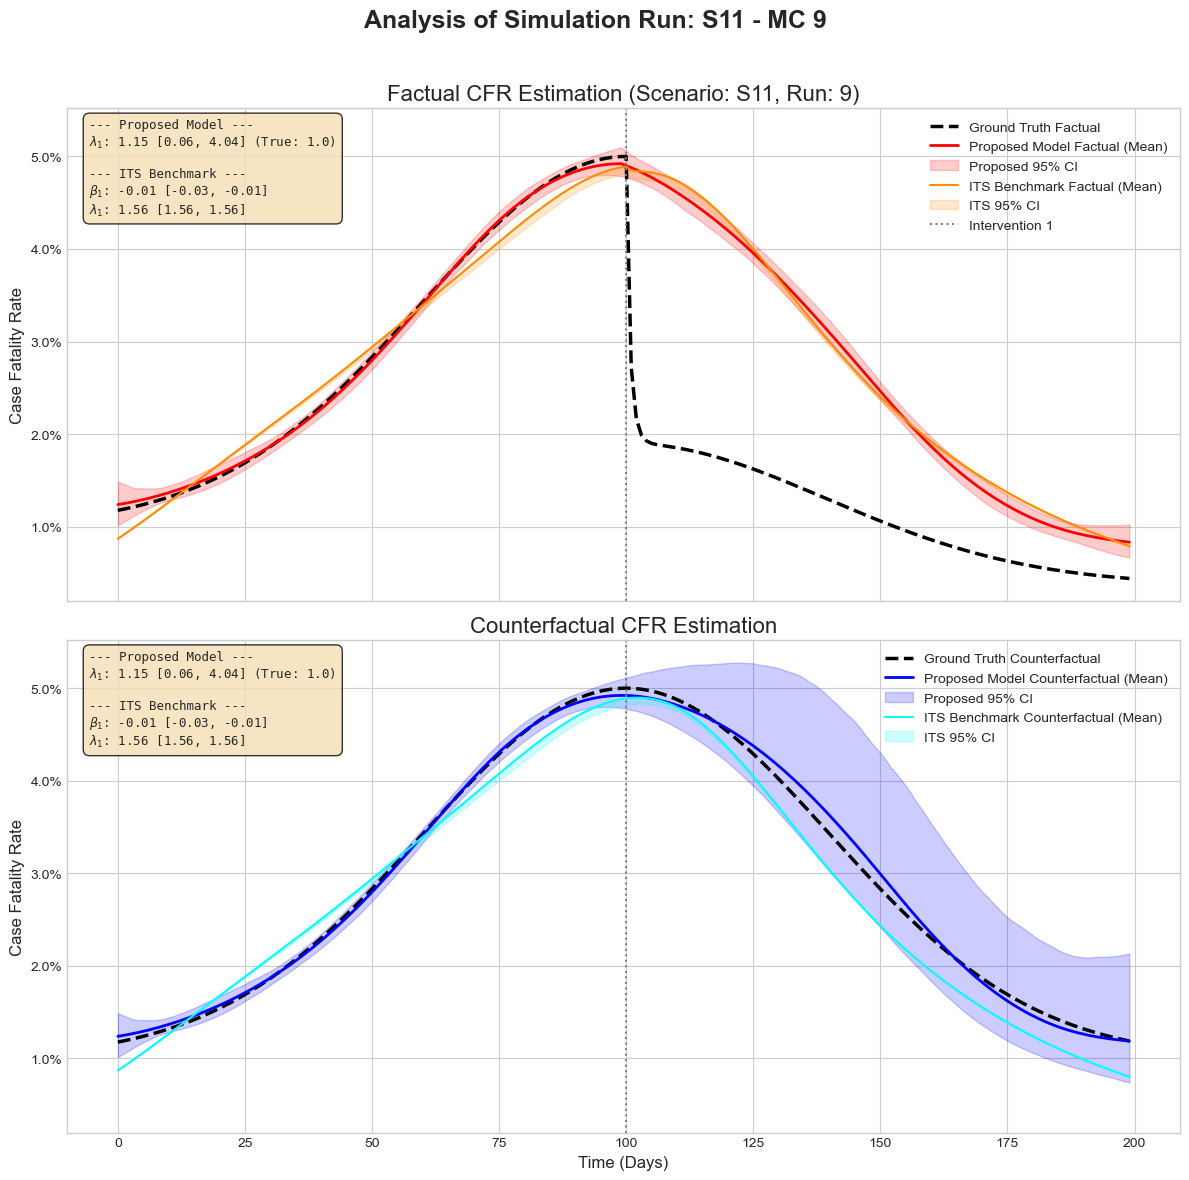

In [103]:
# --- Configuration ---
SCENARIO_ID = 'S11' 
MC_RUN_ID = 8  # We will visualize the sixth Monte Carlo run (which corresponds to run_6 in filenames)

# This block allows the script to be run from the command line.
# It will attempt to load the specified data and generate the plot.
# If the data is not found, it will generate a placeholder plot.
plot_simulation_results(SCENARIO_ID, MC_RUN_ID)

In [97]:
# scenario_id, mc_run_id =  SCENARIO_ID, MC_RUN_ID
# posterior_summary, benchmark_results = load_data(scenario_id, mc_run_id)
# # The ground truth data is now sourced from the benchmark_results object
# truth = benchmark_results

In [98]:
# from data_generation import *

In [100]:
# scenario_info = next(s for s in config.SCENARIOS if s['id'] == scenario_id)
# truth = simulate_scenario_data(scenario_info, 2025)

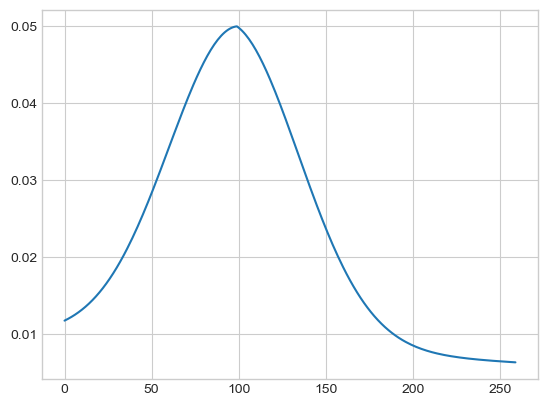

In [101]:
# plt.plot(truth["true_r_0_t"])

In [111]:
# num_interventions = scenario_info['num_interventions_K_true']
# T = 200
# time_pts = np.arange(T)
# I_eff_true = np.zeros(T)
# if num_interventions > 0:
#     true_betas = scenario_info['true_beta_abs_0'] * scenario_info['true_beta_signs_0']
#     true_lambdas = scenario_info['true_lambda_0']
#     true_times = scenario_info['true_intervention_times_0']
    
#     for k in range(num_interventions):
#         time_since_intervention = np.maximum(0, time_pts - true_times[k])
#         Z_k = 1 - np.exp(-true_lambdas[k] * time_since_intervention)
#         I_eff_true += Z_k * true_betas[k]

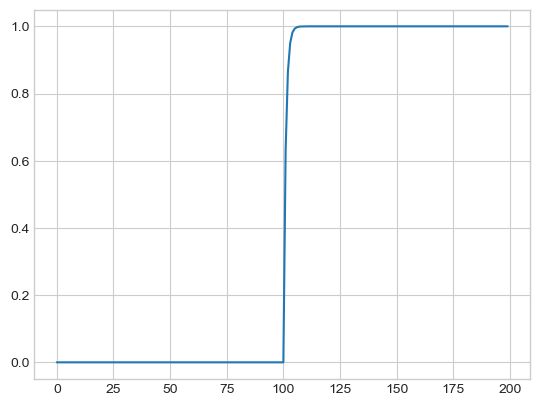

In [114]:
# plt.plot(Z_k)

In [109]:
# true_betas = scenario_info['true_beta_abs_0'] * scenario_info['true_beta_signs_0']
# true_lambdas = scenario_info['true_lambda_0']
# true_times = scenario_info['true_intervention_times_0']
# time_since_intervention = np.maximum(0, time_pts - true_times[0])
# time_since_intervention

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80

In [118]:
# rng_numpy = np.random.default_rng(2025)
# T_sim = config.T_SERIES_LENGTH_SIM
# T_analyze = config.T_ANALYSIS_LENGTH

# baseline_ct_params = {
#     "v_shape_max_cases": config.C_T_VSHAPE_MAX_CASES,
#     "v_shape_slope": config.C_T_VSHAPE_SLOPE,
#     "v_shape_peak_time_factor": config.C_T_VSHAPE_PEAK_TIME_FACTOR,
#     "constant_cases": config.C_T_CONSTANT_CASES 
# }
# baseline_c_t = generate_deterministic_baseline_case_counts(
#     T_sim, T_analyze, config.C_T_FUNCTION_TYPE, baseline_ct_params, config.MIN_DRAWN_CASES
# )

# # Generate basis and intervention matrices
# Bm_true, t_array_scaled_sim, time_scaler = generate_bspline_basis(T_sim, config.N_SPLINE_KNOTS_J, config.SPLINE_ORDER)

In [115]:
# scenario_config_dict = scenario_info
# num_interventions_K_true = scenario_config_dict["num_interventions_K_true"]
# true_beta_abs_0 = scenario_config_dict["true_beta_abs_0"]
# true_lambda_0 = scenario_config_dict["true_lambda_0"]
# true_intervention_times_0_abs = scenario_config_dict["true_intervention_times_0"]
# true_beta_signs_0 = scenario_config_dict["true_beta_signs_0"]

In [119]:
# Z_input_true = generate_intervention_input_matrix(
#     t_array_scaled_sim, true_intervention_times_0_abs, 
#     time_scaler, num_interventions_K_true
# )

# intervention_effect_on_logit_cfr = np.zeros(T_sim)
# true_beta_0_vector = np.array([])
# if num_interventions_K_true > 0:
#     true_beta_0_vector = true_beta_abs_0 * true_beta_signs_0
#     lag_matrix_true = (1 - np.exp(-true_lambda_0 * Z_input_true))
#     intervention_effect_on_logit_cfr = np.dot(lag_matrix_true, true_beta_0_vector)

# # effect_on_log_ct = config.C_T_INTERVENTION_EFFECT_SCALAR * intervention_effect_on_logit_cfr
# # c_t_final = baseline_c_t * np.exp(effect_on_log_ct)
# # c_t_final = np.maximum(config.MIN_DRAWN_CASES, np.round(c_t_final)).astype(int)

In [121]:
# Z_input_true

array([[-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0